### Deep Learning Homework 3

Note: * indicates a non-compulsory extra exercise. We won't penalize you if your notebooks won't contain solutions to these.

As for previous labs, please provide your solutions in a Jupyter Notebook, trying to interleave code cells with markdown cells to explain what you're doing (if not trivial).

1. Implement L1 norm regularization as a custom loss function
2. The third-to-last paragraph in the notebook is concerning early stopping, an "old" regularization technique which involves the stopping of training earlier than the number of epochs would suggest. Read the paragraph and download the paper from Prechelt et al.

    1. Implement early stopping in the E_{opt} specification
    2. \*Implement early stopping in one of the additional specifications

3.  \*(from Lab 2) We have seen how to implement the Quadratic Loss for multinomial classification problems. Read the paper from Demirkaya et al. (in which the Quadratic Loss is introduced along with its issues) and try implementing Correct Class Quadratic Loss (CCQL) in PyTorch as well.

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pylab as pl
from IPython.display import clear_output
import seaborn as sns
sns.set_theme()


# Training and other functions
from scripts import *

In [5]:
B.mro()

[__main__.B, __main__.A, object]

In [14]:
class A:
    def foo(self):
        print("foo")
        
class B(A):
    def bar(self):
        self.foo()
        print("bar")
        
b = B()
b.bar()

foo
bar


In [2]:
# 1. Implement L1 norm regularization as a custom loss function

class L1_loss:
    """
    Implements the L1 norm regularization loss function
    
    Parameters
    ----------
    model: nn.Module
        Model to apply the regularization
    
    n_observations: int
        Number of observations in the training data, required to make the amount
        of regularization independent from the training set size
        
    loss: function with signature loss(output, target, **kwargs) -> float, optional
        Loss function to penalize, Default: nn.MSELoss
    
    L1_coef: float, optional
        L1 regularization parameter, the higher the more regularization is applied  
        Default: 1e-4    
        
    number_of_classes: int, optional
        Set this as the number of classes of the target if you want to use a regression loss
        (for example MSELoss) when the problem is a classification one. Default=None
    """
    def __init__(self, model: nn.Module, n_observations: int, loss: torch.nn = nn.MSELoss(),
                 L1_coef: float = 1e-4, number_of_classes = None) -> None:
        self.model = model
        self.n_observations = n_observations
        self.loss = loss
        self.l1 = L1_coef
        self.num_classes = number_of_classes
    
    
    def __call__(self, output: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        output: torch.Tensor
            Prediction of the model

        target: torch.Tensor
            True label of the predictions
            
        Returns
        -------
        loss: float
            L1 penalized loss on the given data and model
        """
        if self.num_classes is not None:
            target = nn.functional.one_hot(target.long(), self.num_classes).float()
        loss = self.loss(output, target)
        regularization = 0
        for name, param in self.model.named_parameters():
            if '.weight' in name:
                regularization += torch.norm(param, 1)
        
        return loss + (self.l1/self.n_observations)*regularization

In [3]:
from copy import deepcopy


# 2.a Implement the first class of early stopping criteria described on the paper of Prechelt et al.
class stop_by_threshold:
    """
    Implements a early stopping criteria based on the validation loss
    Training is stopped when Loss_current > a*Loss_best
    i.e. the loss on the validation set gets bigger than the minimum
    loss ever achivied on the validation set times a constant a>1
    
    Parameters
    
    threshold: float, optional
        Threshold when to stop training, Default=1.05
        
    Attributes
    ----------
    E_opt: float
        Best validation loss ever reached so far
    best_model: nn.state_dict()
        Stores the model with the best validation loss
    """
    def __init__(self, threshold = 1.05):
        self.threshold = threshold
        self.E_opt = None
        self.best_model = None
    
    
    def __call__(self, val_loss, model):
        """
        Parameters
        ----------
        val_loss: float
            Validation loss of the model

        model: nn.Module
            Current model, only needed to get the state_dict()
            
        Returns
        -------
        stop_training: bool
            Tells whether to stop the training or not
        """
        # Update E_opt if I get a smaller validation loss
        if self.E_opt is None or val_loss < self.E_opt:
            self.E_opt = val_loss
            self.best_model = deepcopy(model.state_dict())
            return False
        
        # Continue training if GL is lower than the threshold
        GL = val_loss/self.E_opt
        if GL < self.threshold:
            return False
        
        # Otherwise stop training
        return True
    
    
# 2.b Implement the third class of early stopping criteria described on the paper of Prechelt et al.
class stop_by_increase:
    """
    Implements a early stopping criteria based on the validation loss
    Training is stopped when Loss_t > Loss_t-gap
    i.e. the loss on the validation set gets bigger than the
    validation loss gap epochs before
    
    Parameters
    
    gap: float, optional
        The gap parameter explained above, Default=5
        
    Attributes
    ----------
    E_opt: float
        Best validation loss ever reached so far
    best_model: nn.state_dict()
        Stores the model with the best validation loss
    val_losses: list of float
        Stores the validation losses so far
    """
    def __init__(self, gap = 5):
        self.gap = gap
        self.E_opt = None
        self.best_model = None
        self.val_losses = []
        
    def __call__(self, val_loss, model):
        """
        Parameters
        ----------
        val_loss: float
            Validation loss of the model

        model: nn.Module
            Current model, only needed to get the state_dict()
        
        Returns
        -------
        stop_training: bool
            Tells whether to stop the training or not
        """
        self.val_losses.append(val_loss)
        # Update E_opt if I get a smaller validation loss
        if self.E_opt is None or val_loss < self.E_opt:
            self.E_opt = val_loss
            self.best_model = deepcopy(model.state_dict())
            return False
        
        # Continue training if the loss is less than the loss 'gap' iterations before
        if val_loss < self.val_losses[-self.gap - 1]:
            return False
        
        # Otherwise stop training
        return True

In [4]:
# 3. Correct class Quadratic Loss CCQL

class CCQL:
    """
    Correct class Quadratic Loss loss function

    Parameters
    ----------
    loss: function with signature loss(output, target, **kwargs) -> float
        Loss function to penalize, Default: nn.MSELoss
    
    CC_bias: float, optional
        Correct Class bias parameter, the higher the more the loss is biased
        towards the correct class, good values are CC_bias=sqrt(K-1)-1 with
        K=number of classes, Default: 2
        Default: 1e-4    
    
    number_of_classes: int, optional
        Set this as the number of classes of the target if you want to use a regression loss,
        for example MSELoss, when the problem is a classification one. Default=None
    """          
    def __init__(self, loss: torch.nn = nn.MSELoss(), CC_bias: float = 2, number_of_classes = None) -> None:
        self.w = CC_bias
        self.loss = loss
        self.num_classes = number_of_classes
        

    def __call__(self, output: torch.Tensor, target: torch.Tensor):
        """
        Parameters
        ----------
        output: torch.Tensor
            Prediction of the model

        target: torch.Tensor
            True label of the predictions
        
        Returns
        -------
        loss: float
            CCQL loss on the given data
        """ 
        # Correct class bias
        correct_class = [output[i, target[i]] for i in range(len(target))]
        loss = 0.5 * self.w * torch.mean((1-torch.Tensor(correct_class))**2)
        
        # Baseline loss
        if self.num_classes is not None:
            target = nn.functional.one_hot(target.long(), self.num_classes).float()
        loss += self.loss(output, target)
    
        return loss

## Testing

Now I test the functions implemented above

In [12]:
# Define a neural net
class MLP(nn.Module):
    """
    Implements a neural network to train on MNIST 
    """
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(784, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,10)
        )
        
    def forward(self, X):        
        return self.layers(X)

In [6]:
# Load the data
import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize

# Change root_dir to the directory where to find MNIST
root_dir = '../data/'
transforms = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,))
    ])

# Training and test sets
train_set = torchvision.datasets.MNIST(root=root_dir, train=True, transform=transforms)
test_set = torchvision.datasets.MNIST(root=root_dir, train=False, transform=transforms)

# Create train and test loaders
batch_train, batch_test = 64, 512
train_loader = DataLoader(train_set, batch_size=batch_train, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_test, shuffle=False, num_workers=2)

## Testing Loss functions

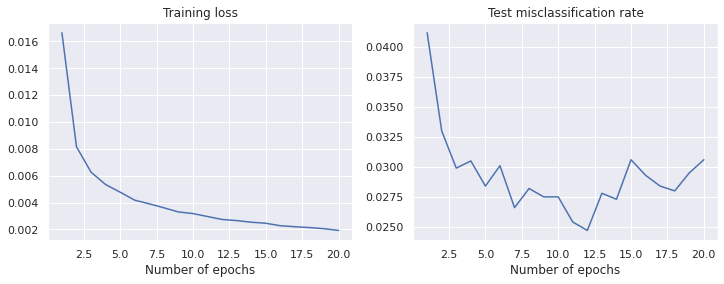

In [7]:
# I train a net with L2 loss for comparison
net = MLP()
# I use my loss function because nn.MSELoss expects one-hot encoding
loss = L1_loss(net, 50000, L1_coef=0., number_of_classes=10)
optimizer = torch.optim.Adam(net.parameters())
train_losses, test_losses = train_model(net, train_loader, loss, optimizer, n_epochs=20, 
                                        val_set=test_loader, val_criterion=accuracy)
clear_output()

plot_train_test(train_losses, test_losses)

We were able to achive a baseline error rate on the test set of about 3% at the end of training, we missed out on the minima at epoch 12, a early stopping procedure would have been very good in this case

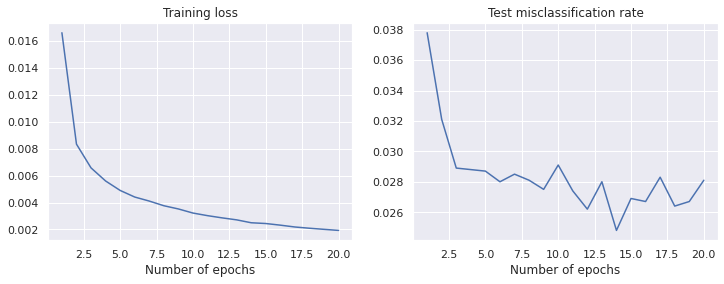

In [13]:
# Testing L1 loss
net = MLP()
loss = L1_loss(net, 50000, L1_coef=5e-4, number_of_classes=10)
optimizer = torch.optim.Adam(net.parameters())
train_losses, test_losses = train_model(net, train_loader, loss, optimizer, n_epochs=20, 
                                        val_set=test_loader, val_criterion=accuracy)
clear_output()

plot_train_test(train_losses, test_losses)

We see that L1 regularization with $\lambda=5\cdot 10^{-4}$ we get a similar result

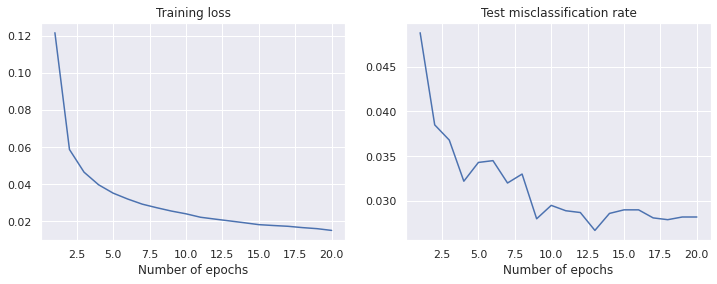

In [10]:
# Testing CCQL loss
net = MLP()
loss = CCQL(number_of_classes=10)
optimizer = torch.optim.Adam(net.parameters())
train_losses, test_losses = train_model(net, train_loader, loss, optimizer, n_epochs=20, 
                                        val_set=test_loader, val_criterion=accuracy)
clear_output()

plot_train_test(train_losses, test_losses)

In this problem CCQL helps a little, we were able to reach a missclassification rate of about 2.8%, we used $\omega=2$ as the correct class bias parameter, this value is the one suggested in the paper: $\omega=\sqrt{K-1}-1$ with $K$: number of classes

## Testing early stopping

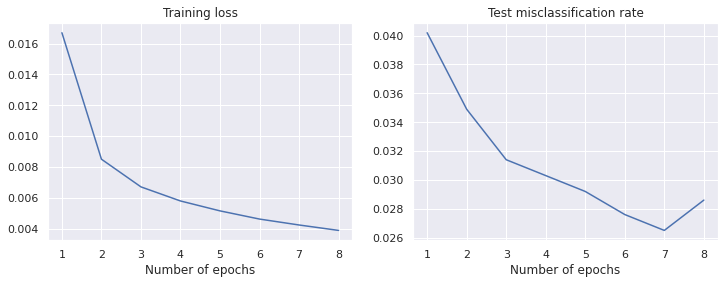

In [11]:
# Testing the first class of early stopping rules
net = MLP()
loss = L1_loss(net, 50000, L1_coef=0., number_of_classes=10)
optimizer = torch.optim.Adam(net.parameters())
train_losses, test_losses = train_model(net, train_loader, loss, optimizer, n_epochs=20, 
                                        val_set=test_loader, val_criterion=accuracy,
                                       stopping_criterion=stop_by_threshold())
clear_output()

plot_train_test(train_losses, test_losses)

With the first class of early stopping criteria training stops after 8 epochs and we got a minima of about 2.7% test misclassification rate, in this case we both improved the performance of the classifier and reduced training time by over 50%

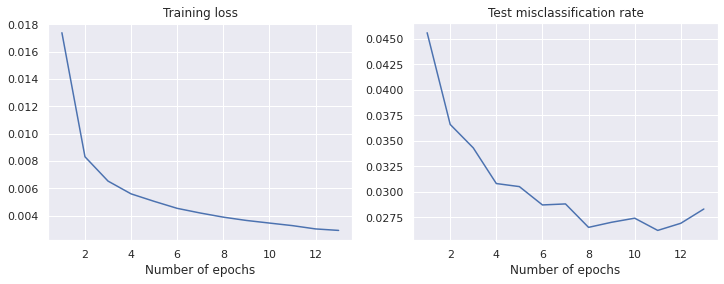

In [13]:
# Testing the first of the third class of early stopping rules
net = MLP()
loss = L1_loss(net, 50000, L1_coef=0., number_of_classes=10)
optimizer = torch.optim.Adam(net.parameters())
train_losses, test_losses = train_model(net, train_loader, loss, optimizer, n_epochs=20, 
                                        val_set=test_loader, val_criterion=accuracy,
                                       stopping_criterion=stop_by_increase())
clear_output()

plot_train_test(train_losses, test_losses)

Finally we tested the third class of early stopping criteria, in particular $UP_1$ with $k=5$, in this case training stops after 12 epochs so we saved less than half of the training time but we are able to reach a better minima

### Conclusion

The descriptions above refer to a particular run of tests, if we rerun all the tests we can get different results, by running the test multiple times we saw that the neural network converges to good minimas even without L1 regularization and CCQL, however a bit of L1 regularization doesn't hurt either, while the effect of CCQL are a little subtler, sometimes it helps, other times it doesn't, in the paper the author saw a big difference with CIFAR-100 which is composed of 100 classes, while MNIST only has 10 classes, so maybe this isn't the problem where it is needed to bias the correct class.  

A nice surprise was early stopping: it always reduces training times by about a half and sometimes it manages to find better minimas than the other methods, however it must be said that these minimas are chosen such that to minimize the error on the validation set, so we can't reliably say that early stopping finds better minimas, to prove this we should have a separate test set, still the first point still remains: early stopping reduces training times by about a half.  

It must be said that the conclusion stated above hold for small MLPs, the result could be different or completely opposite for current-day neural networks